# GDP-10 더 멋진 번역기 만들기


- GDP 08에서, seq2seq 를 이용해 한-영 번역기를 만들어보았습니다만, 그다지 성능이 좋지 못한 걸 확인할 수 있었습니다. 
- 이번 프로젝트에선 transformer를 이용해 더 멋진 번역기를 만들어 봅니다. 
- 데이터셋은 GDP-08에서 사용했던 데이터셋을 그대로 사용합니다. 

\\

-----

# 루브릭 평가 기준


| 평가문항 | 상세기준 |
| --- | --- |
| 1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다. | 데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다. |
| 2. Transformer 번역기 모델이 정상적으로 구동된다. | Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다. |
| 3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다. | 제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다. |

\\

-----

# 1. 데이터 및 라이브러리 불러오기


* 이번 시간에 사용할 데이터셋은, GDP-08과 동일하기 때문에, 데이터셋을 받는 작업은 필요하지 않습니다.
- 프로젝트에 사용할 데이터셋과 라이브러리를 불러옵니다. 


## &nbsp;&nbsp; 1-1 라이브러리 불러오기 


- 프로젝트에 필요한 라이브러리를 불러옵니다.
- 이번 시간에도 한국어 데이터를 다루기 때문에, 

In [23]:
#sentencepiece 설치 
! pip install sentencepiece

In [47]:
import pandas as pd
import numpy as np
import os, re, random, io 
import tensorflow as tf
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

# sentencepiece
import sentencepiece as spm

# tqdm
from tqdm.notebook import tqdm   
from tqdm import tqdm_notebook

In [25]:
# 폰트 설치!
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/content/drive/MyDrive/AIFFEL/font/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


In [26]:
# 폰트 설치 - 폰트 깨졌을 때! 
# 폰트 설치 후, 런타임 재시작 해야 안깨짐 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


## &nbsp;&nbsp; 1-2 데이터셋 불러오기 

- 프로젝트에서 사용할 데이터셋을 불러옵니다. 
- GDP-08 과 성능을 비교해 주기 위해, 동일한 데이터양을 사용하겠습니다. 

In [27]:
# 데이터셋이 있는 디렉토리로 이동합니다. 
os.chdir('/content/drive/MyDrive/AIFFEL/mkdir/s2s_translation')

In [28]:
! ls

korean-english-park.dev.en	korean-english-park.test.tar.gz
korean-english-park.dev.ko	korean-english-park.train.en
korean-english-park.dev.tar.gz	korean-english-park.train.ko
korean-english-park.test.en	korean-english-park.train.tar.gz
korean-english-park.test.ko


In [29]:
# train 데이터 경로 할당
path_ko_train = 'korean-english-park.train.ko'
path_en_train = 'korean-english-park.train.en'

\\

-----

# 2. 데이터 전처리 


- 살펴보기 작업은 08에서 해 줬기 때문에, 생략합니다.
- 주어진 조건에 맞게 데이터를 전처리 해 줍니다.
- 전처리에 필요한 함수를 만들어 주고, 중복을 제거한 다음, 토큰화를 진행합니다.

- LMS 내 `clean_corpus` 코드 중, `assert len(kor) == len(eng)` 부분이 있는데, 이건 가정설정문 이라해서 뒤의 조건이 True 가 아니라면 AssertError가 발생한다. 값을 보증하기위해서 사용한다나..   
[Assert에 대한 설명](https://wikidocs.net/21050)


## &nbsp;&nbsp; 2-1 중복 제거하기

- `set` 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다.
-  데이터의 병렬 쌍이 흐트러지지 않게 주의하세요!  
- 중복을 제거한 데이터를 `cleaned_corpus` 에 저장합니다.

In [103]:
# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    # zip으로 데이터 쌍 묶어주기 
    raw = zip(kor, eng)

    # set으로 중복 제거!
    cleaned_corpus = list(set(raw))

    return cleaned_corpus

cleaned_corpus = clean_corpus(path_ko_train, path_en_train)

## &nbsp;&nbsp; 2-2 정제 함수 만들기


- 데이터의 불필요 단어 등을 정제하는 함수를 다음과 같은 조건에 맞게 만들어줍니다.
> - 모든 입력을 소문자로 변환합니다.  
> - 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
> - 문장부호 양옆에 공백을 추가합니다.
> - 문장 앞뒤의 불필요한 공백을 제거합니다.


In [136]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    # 영어 대문자를 소문자로 바꾸고, 양쪽 공백을 지워줍니다. 
    sentence = sentence.lower().strip()

# 첫번째 그룹에 해당하는 애들에 공백을 주세요
# r 뒤에 오는 것들은 정규표현식에 사용되는 문자열
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

# 가-힣a-zA-Z?.!, 를 제외한 모든것들을 공백으로 바꾼다.
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)

# 문장부호 사이에 공백 추가하기 
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

# 여러개 공백을 하나의 공백으로바꿔주세요 
    sentence = re.sub(r'[" "]+', " ", sentence)    

# 불필요한 공백 제거 
    sentence = sentence.strip()
    
    return sentence

* 정제함수, 잘 만들어 졌을까요? 영어와 한국어, 숫자 등등이 들어간 문장을 통해 확인 해 봅시다! 

In [137]:
sentence = 'Hark the heralds, anchors aweigh! Hither happens mine escape. -> 이 예고를 들어라, 닻을 올려라! 여기서 탈출은 시작된다.'

preprocess_sentence(sentence)

'hark the heralds , anchors aweigh ! hither happens mine escape . 이 예고를 들어라 , 닻을 올려라 ! 여기서 탈출은 시작된다 .'

## &nbsp;&nbsp; 2-3 토큰화!


- Sentencepiece를 활용해 토큰화 해 줍니다.
- en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.

> - 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
- 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
- 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
`<PAD> : 0 / <BOS> : 1 / <EOS> : 2 / <UNK> : 3`
>

In [138]:
kor_corpus = []
eng_corpus = []

for tmp in cleaned_corpus:
    tmp_ko = preprocess_sentence(tmp[0])
    tmp_en = preprocess_sentence(tmp[1], s_token=True, e_token=True)
    kor_corpus.append(tmp_ko)
    eng_corpus.append(tmp_en)

print(len(kor_corpus))
print(len(eng_corpus))
print("Korean:", kor_corpus[100])   
print("English:", eng_corpus[100])

78968
78968
Korean: 로즈원은 조지는 핏불의 공격을 방어하고 또 짖으며 우리를 보호했다 며 그러나 핏불들이 조지의 머리와 등 부분을 물기 시작했고 우리들의 울음 소리를 들은 주민들이 현장으로 달려왔다 고 밝혔다 .
English: george tried to protect us by barking and rushing at them , but they started to bite him one on the head and the other on the back , rosewarne said . we ran off crying and some people saw what was happening and rescued george .


In [139]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus, vocab_size,lang="ko", pad_id=0, bos_id=1, eos_id=2, unk_id=3):
    # 모델 이름 설정 - sentencepiece model + language (처음에 변수로 선언되어있음) 
    model_name = 'spm_gdp10_'+lang

    # sentencepiece 모델 생성 경로 설정 
    temp_file = '/content/drive/MyDrive/AIFFEL/mkdir/s2s_translation' +lang+'.ko'

    # 함수 파라미터 lang의 단어를 적용한 파일 코퍼스 파일을 만듬? 
    with open(temp_file, 'w') as f: # lang corpus 활용 
        for row in corpus:
            f.write(str(row) + '\n')

    spm.SentencePieceTrainer.Train(
            '\
            --input={} \
            --model_prefix={} \
            --vocab_size={} \
            --pad_id={} \
            --bos_id={} \
            --eos_id={} \
            --unk_id={}'.format(temp_file, model_name, vocab_size, pad_id, bos_id, eos_id, unk_id)    
        )
        #위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.
        
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(model_name+'.model')
        
    return tokenizer


In [140]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000


ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

- 모델과 vocab이 생성 되었는지 확인합니다. 

In [141]:
!ls -l

total 36751
-rw------- 1 root root   134786 Jul 12  2014 korean-english-park.dev.en
-rw------- 1 root root   159673 Jul 12  2014 korean-english-park.dev.ko
-rw------- 1 root root   113461 Apr 11 05:50 korean-english-park.dev.tar.gz
-rw------- 1 root root   278586 Jul 12  2014 korean-english-park.test.en
-rw------- 1 root root   322388 Jul 12  2014 korean-english-park.test.ko
-rw------- 1 root root   229831 Apr  6 06:17 korean-english-park.test.tar.gz
-rw------- 1 root root 11982221 Jul 12  2014 korean-english-park.train.en
-rw------- 1 root root 13730884 Jul 12  2014 korean-english-park.train.ko
-rw------- 1 root root  8718893 Apr  6 06:17 korean-english-park.train.tar.gz
-rw------- 1 root root   575499 Apr 12 11:05 spm_gdp10_en.model
-rw------- 1 root root   355533 Apr 12 11:05 spm_gdp10_en.vocab
-rw------- 1 root root   623607 Apr 12 11:05 spm_gdp10_ko.model
-rw------- 1 root root   403527 Apr 12 11:05 spm_gdp10_ko.vocab


- 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환 해 줍니다. 

In [142]:


src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)


# 토큰의 길이가 50 이하인 문장만 남깁니다.
for idx in tqdm_notebook(range(len(kor_corpus))):
    token_ko = ko_tokenizer.encode_as_ids(kor_corpus[idx]) # 서브워드 시퀀스 변환
    token_en = en_tokenizer.encode_as_ids(eng_corpus[idx]) # 정수 시퀀스 변환
       
        
    if len(token_ko) <= 50  and len(token_en) <= 50:
        src_corpus.append(token_ko)
        tgt_corpus.append(token_en)

# 토큰 길이 정제 확인       
print(len(src_corpus))
print(len(tgt_corpus))
print("Korean:", src_corpus[10])
print("-"*80)
print("English:", tgt_corpus[10])
    

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/78968 [00:00<?, ?it/s]

72143
72143
Korean: [126, 17014, 377, 8077, 5037, 3595, 6, 1093, 18638, 2472, 7, 33, 1540, 1944, 657, 11, 10, 1378, 4]
--------------------------------------------------------------------------------
English: [1, 4, 851, 11, 16643, 7, 30, 4, 62, 1815, 21, 1275, 11, 1408, 13, 951, 2960, 1894, 123, 960, 43, 8, 364, 59, 27, 9319, 92, 10, 67, 1062, 200, 5, 3657, 3517, 8, 258, 4, 387, 60, 57, 106, 5, 2]


In [143]:
# 토큰화 된 데이터셋 확인! 
print(enc_train.shape)
print(dec_train.shape)

(72143, 50)
(72143, 50)


\\

-----

# 3. 모델 설계


- 이번 시간에 만든 모듈을 하나하나 조립해 트랜스포머 모델을 만듭니다. 

## &nbsp;&nbsp; 3-1 Positional_encoding

- 이전 강의 노드에서 구현한 코드를 가져와서 사용합니다.

In [144]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

print("Positional_encoding! 짜잔!")

Positional_encoding! 짜잔!


\\

## &nbsp;&nbsp; 3-2 Multi-Head Attention

- 여러 개의 서브 모듈을 결합하여 완성됩니다.
    - `split_heads()`
        - Embedding된 입력을 Head 수로 분할
    - `scaled_dot_product_attention()`
        - 분할된 입력으로부터 **Attention 값을 구함**
    - `combine_heads()`
        - 연산이 종료되고 분할된 Head를 다시 하나로 결합시켜줌

- masking 부분은?
    - 마스크의 형태는 모델 외부의 훈련 데이터이기 때문에, 멀티 헤드 어텐션 외부에 정의되야함.
    - 모델을 완성한 후에 마스크를 생성하는 함수를 구현하도록 해야함.
    - 대신 생성된 마스크를 처리할 수 있게 다음 코드를 포함합니다.
    
    ```python
    # scaled_qk: Attention을 위한 Softmax 직전의 Scaled QK
    if mask is not None: scaled_qk += (mask * -1e9)
    ```

In [145]:
# Multi-Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

\\

## &nbsp;&nbsp; 3-3 Position-wise Feed-Forward Network

- `d_ff` : 논문의 설명대로라면 2048
- `d_model` : 512
- `[ batch x length x d_model ]` : 입력 받고
- `w_1` :  2048차원으로 매핑하고 활성함수 ReLU를 적용
- `w_2` : 를 통해 512차원으로 되돌리는 과정!
- 이렇게 쉽게 FFN 완성입니다! (짜잔)

In [146]:
# Position-wise Feed-Forward Network 구현 
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("Position-wise Feed-Forward Network 구! 현! ")

Position-wise Feed-Forward Network 구! 현! 


\\

-----

# 4. Encoder, Decoder

- Encoder 와 Decoder레이어를 만듭니다.
- 정의한 레이어로 Encoder와 Decoder를 정의합니다.


## &nbsp;&nbsp; 4-1 Encoder 레이어 구현하기 

In [147]:
# Encoder 레이어 
# 이걸 토대로 Decoder 레이어를 구현하믄 된댕 
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

print("Encoder 레이어 구현! 완 료! ")

Encoder 레이어 구현! 완 료! 


\\

## &nbsp;&nbsp; 4-2 Decoder 레이어 구현하기 

In [148]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

print('Decoder 레이어 구현 완료!')

Decoder 레이어 구현 완료!


\\

## &nbsp;&nbsp; 4-3 Encoder 정의하기 

In [149]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

## &nbsp;&nbsp; 4-4 Decoder 정의하기

In [150]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

\\

-----

# 5. Transformer 완성하기

- 4번에서 정의된 `Encoder` 와 `Decoder` 를 가지고 최종적으로 트랜스포머를 완성합니다!
- 아래 조건을 만족하며 소스의 빈칸을 채워 `Transformer` 클래스를 완성합니다.
- 조건!
    1. `shared` 변수를 매개변수로 받아 `True` 일 경우 **Decoder Embedding과 출력층 Linear의 Weight를 공유** 할 수 있게 하세요! Weight가 공유될 경우 Embedding 값에 **sqrt(d_model)** 을 곱해줘야 하는 것, 잊지 않으셨죠?  
     (참고: `tf.keras.layers.Layer.set_weights()`)
    2. 우리가 정의한 `positional_encoding` 의 반환값 형태는 `[ Length x d_model ]` 인데, 이를 더해 줄 Embedding 값 형태가 `[ Batch x Length x d_model ]` 이라서 연산이 불가능합니다. 연산이 가능하도록 수정하세요!  
     (참고: `tf.expand_dims()`, `np.newaxis`)

In [151]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

\\

-----

# 6. Masking 구현하기 

- 이전 노드에서 배운 generate_causality_mask() 에 generate_padding_mask() , generate_masks() 가 추가됬습니다.

- `generate_padding_mask()`
    - Attention을 할 때에 `<PAD>` 토큰에도 Attention을 주는 것을 방지해 주는 역할을 합니다.
    - 한 배치의 데이터에서 `<PAD>` 토큰으로 이루어진 부분을 모두 찾아내는 마스크를 생성합니다.

- 첫번째 마스크
    - 각 배치 별로 데이터의 꼬리 부분을 Masking 하는 형태
- 두번째, 세번째 Decoder
    - **Causality Mask와 Padding Mask를 결합한 형태**
    - Decoder 역시 `<PAD>` 토큰은 피해 가야 하기 때문에 이런 형태의 마스크가 사용된답니다!
        - padding 마스크랑 결합 한 형태?
        - 역시 읽어보면서 하지 않음 1도 모르겠구만

In [163]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def generate_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask


- Masking 시각화를 통해 확인 해 볼까요?

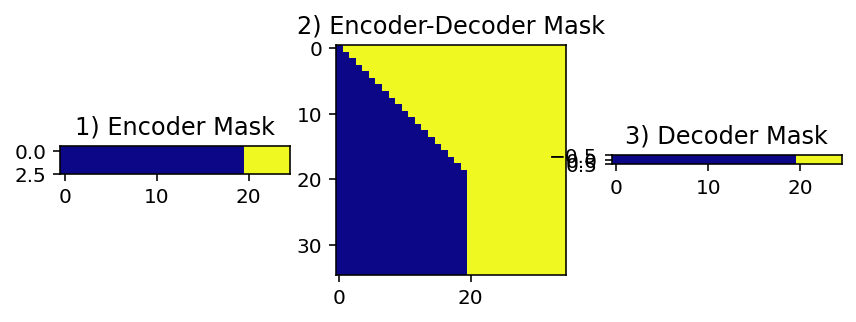

In [164]:
# Masking 시각화

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='plasma')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='plasma')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='plasma')

plt.show()

\\

-----

# 7. Learning Rate Scheduler

- 가변적인 Learning Rate를 사용하기 위해 상속받은 클래스입니다.

In [165]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

\\

-----

# 8. 훈련하기

- 앞서 제작한 것들을 합쳐 모델을 훈련시켜봅시다.
- 결과는 어떨까요? seq2seq 를 이용해 만들었을 때 보다 성능이 올랐을까요? 

## &nbsp;&nbsp; 8-1 Transformer를 선언

In [166]:
transformer = Transformer(
    n_layers = 2,
    d_model = 512,
    n_heads = 8,
    d_ff = 2048,
    src_vocab_size=10000,
    tgt_vocab_size=10000,
    pos_len=50,
    dropout = 0.3
)

## &nbsp;&nbsp; 8-2 Learning Rate, optimizer 선언

- Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.

In [167]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-09, 
    name='Adam')

## &nbsp;&nbsp; 8-3 Loss 함수 정의


- Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다.   
(트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [168]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## &nbsp;&nbsp; 8-4 train_step 함수 정의


- 입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.

In [169]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다.
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

## &nbsp;&nbsp; 8-5 그 외 기타 필요 함수 정의 


- 번역 생성에 필요한 함수를 정의합니다.
- 시각화에 필요한 함수도 정의 해 줍니다. 

In [170]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [171]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [172]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

## &nbsp;&nbsp; 8-6 학습 진행! 


- 매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 제출하세요!

In [173]:
BATCH_SIZE = 32
EPOCHS = 10

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]



for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2255 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 


  0%|          | 0/2255 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 


  0%|          | 0/2255 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 


  0%|          | 0/2255 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 


  0%|          | 0/2255 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 


  0%|          | 0/2255 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 


  0%|          | 0/2255 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 


  0%|          | 0/2255 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 


  0%|          | 0/2255 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 


  0%|          | 0/2255 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: 
Input: 시민들은 도시 속에 산다.
Predicted translation: 
Input: 커피는 필요 없다.
Predicted translation: 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: 


## &nbsp;&nbsp; 8-7 결과확인 및 비교


- 예문을 Attention Map을 시각화 해봅니다.
- seq2seq 모델의 결과값과 비교 해 보겠습니다.

Input: 오바마는 대통령이다.
Predicted translation: 
Encoder Layer 1


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45716 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53685 missing from current font.
  font.set_

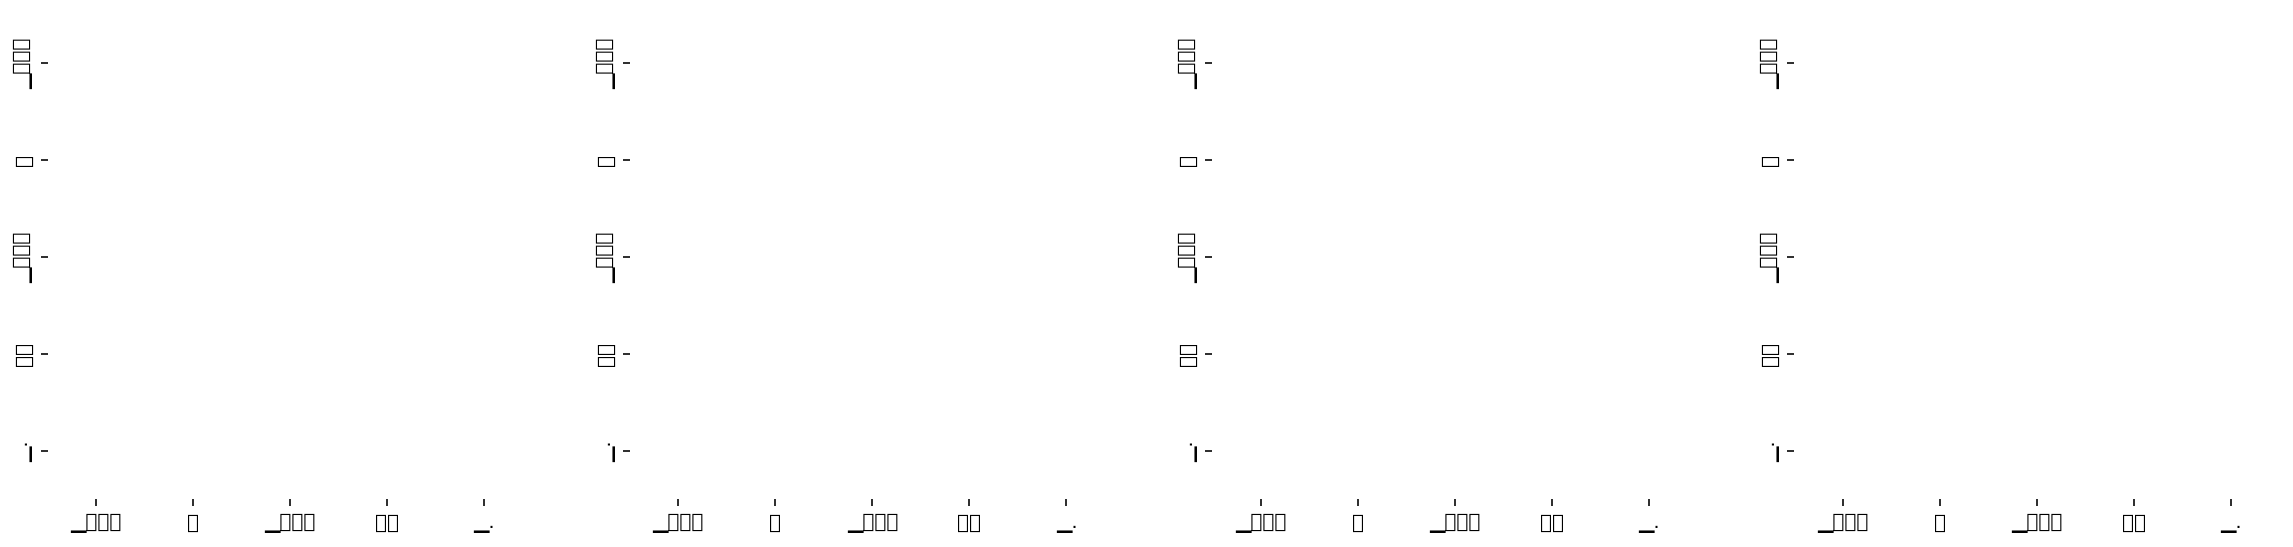

Encoder Layer 2


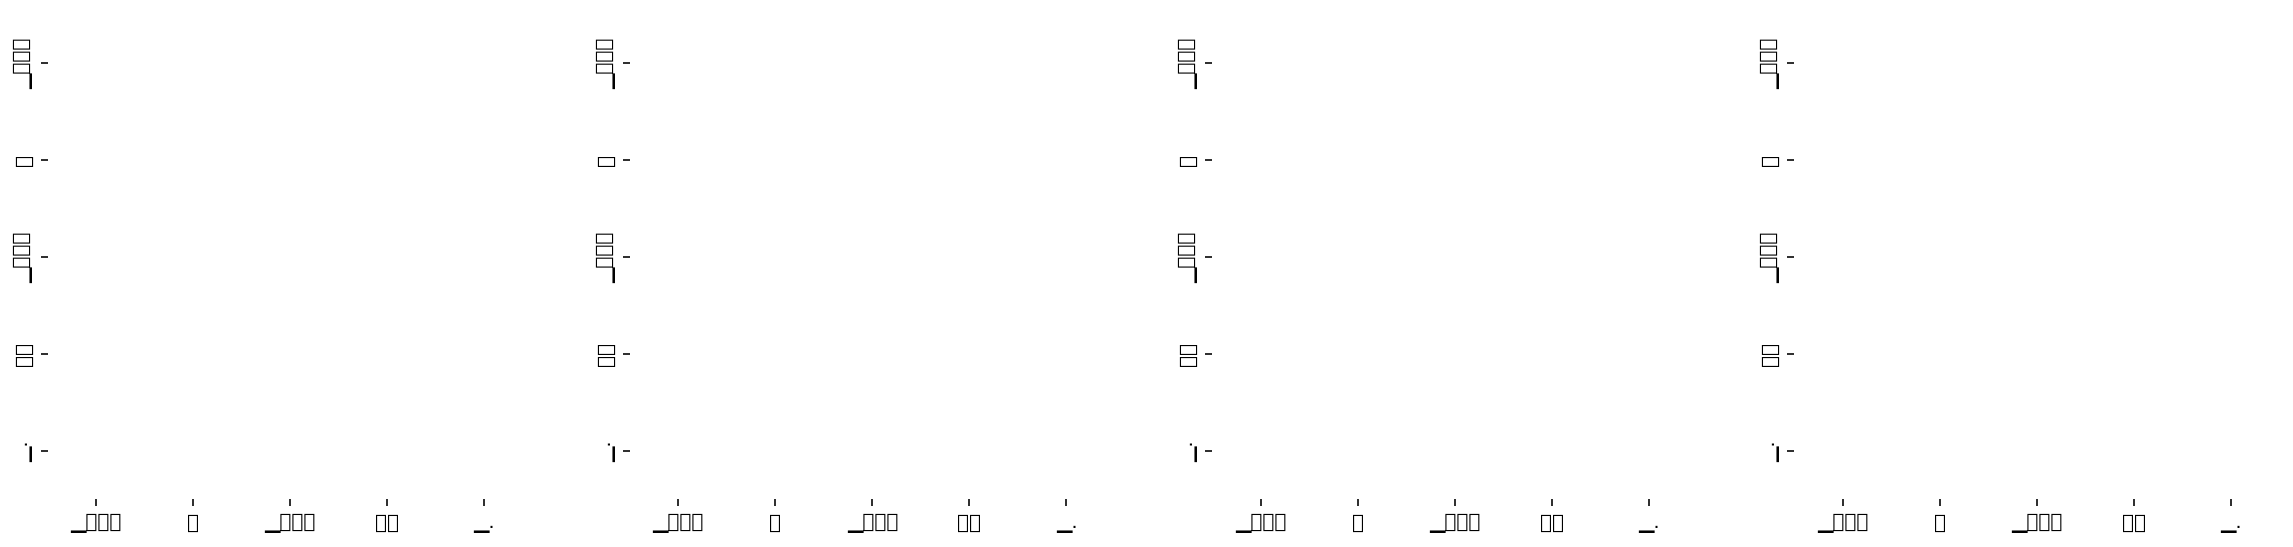

Decoder Self Layer 1


/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


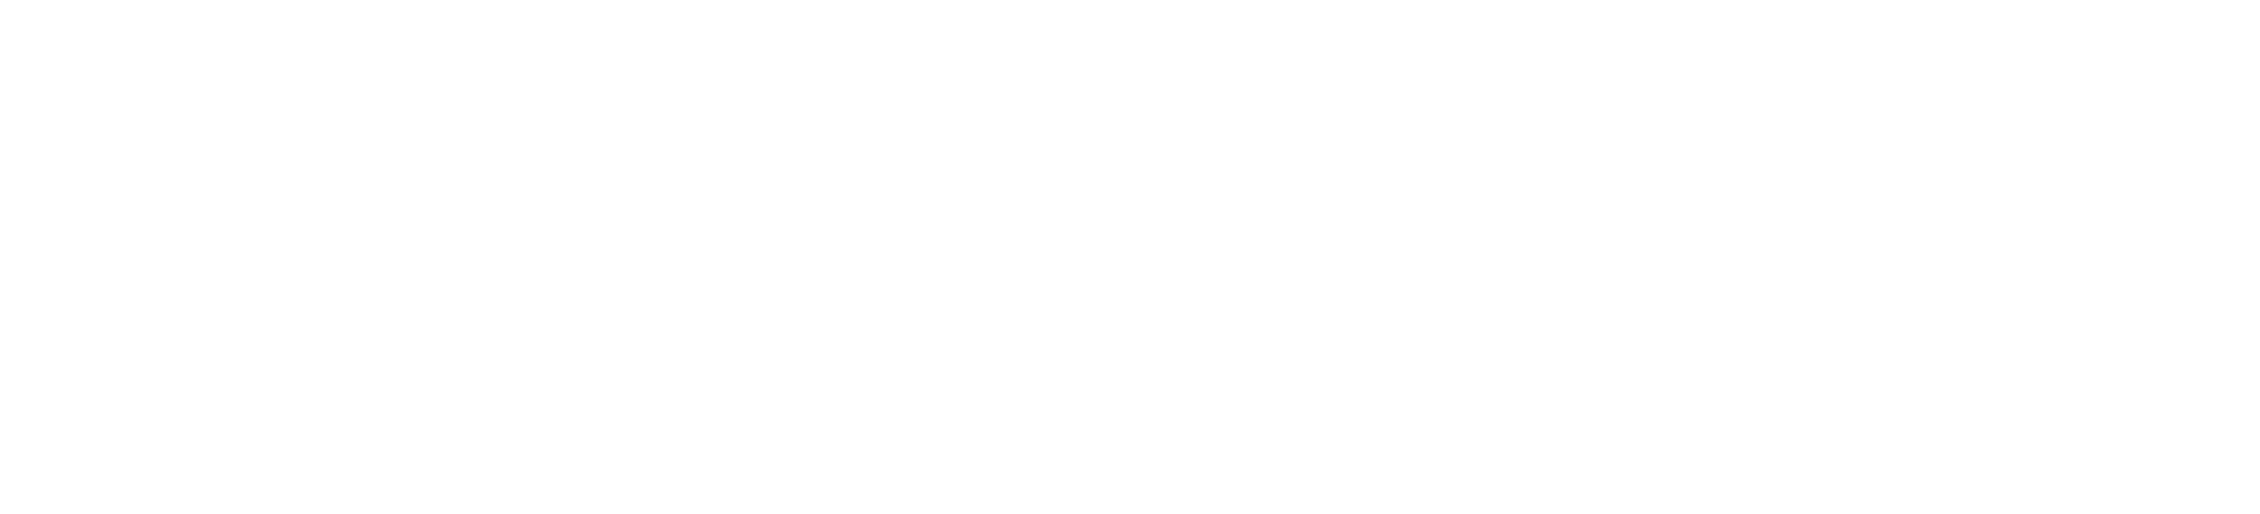

Decoder Src Layer 1


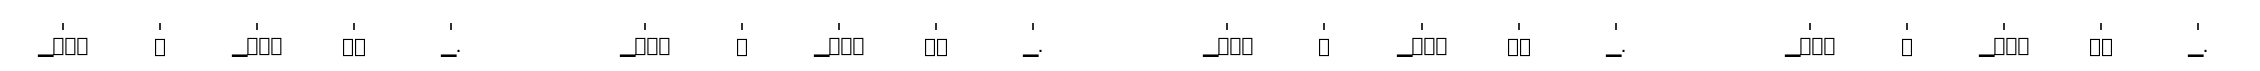

Decoder Self Layer 2


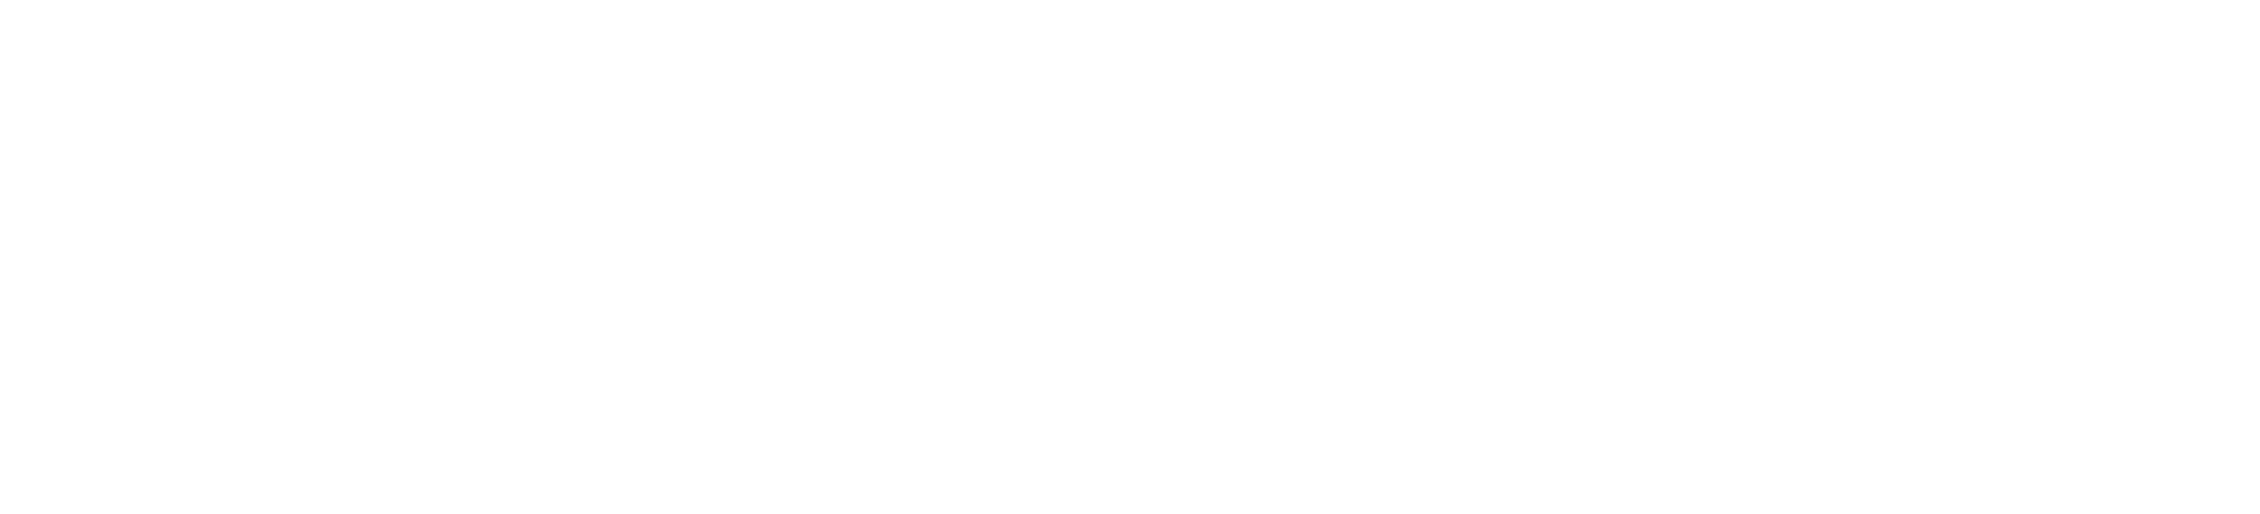

Decoder Src Layer 2


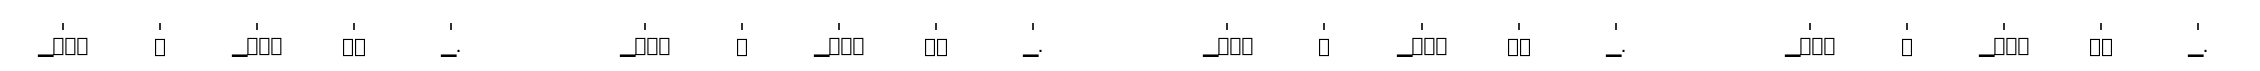

In [175]:
sentence = '오바마는 대통령이다.'
translate(sentence, transformer, ko_tokenizer, en_tokenizer,True)

\\

-----

# 후...기..... 💀


- 학습 진행 부분에서 `invalidargumenterror: in[0] mismatch in[1] shape: 50 vs. 1: [1,8,1,50] [1,8,1,64] 0 0 [op:batchmatmulv2]` 라는 오류가 발생하였다. 
- 텐서가 잘못되었다 라고 나와, 데이터셋을 나누는 코드가 잘못 된 줄 알고, 내가 적었던 코드를 백업하지 않고 지워버린 다음, 전진환님 프로젝트 코드를 가져와 실행 해 보았지만 결과는 동일했다. 작성하신 분이 어떻게 해결 하셨을 지 다시 한번 확인 해 보았더니, masking 부분 함수가 제대로 동작하지 않아 발생한 오류였다고 한다. 덕분에 오류를 해결 할 수 있었고, 현재 열심히 모델은 학습중이다.
- 그렇게 막 거창하고 멋진 코드는 아니였지만,  나름대로 이전에 배웠던 코드라고 좋아하면서 적었는데.. 내가 틀렸더라도 꼭 백업하는 습관을 들여야겠다. 

- 과제.. 미리미리 하자.. 하이퍼 파라미터를 바꿔보면서 결과를 비교해 보는 즐거운 작업을 하지 못했다!! 실제로 결과가 나오지 않아, 미완성으로 제출하게 되었다... 지금 시간이 얼마 남지 않아, 더 이상의 시도를 못 해보는게 넘 아쉽다.. 너무 아쉽다.. 12번도 지금.. 촉박하게 할 것같지만, 시간이 허락하는 만큼 열심히 해서 제출 해 보겠습니다! 죄송합니다! 

\\

-----

# 🖇 참고 페이지


### sentencepiece 관련 

- [wikidocs](https://wikidocs.net/86657)
- [자연어 처리를 위한 Tokenizer & Vocabulary](https://paul-hyun.github.io/nlp-tutorial-02-02-tokenizer/)
- [전진환님 GDP-10 프로젝트](https://github.com/Jeon0866/AIFFEL_GoingDeeper/blob/master/GD10_Transfomer_Translator.ipynb)

### Masking 작동 안되서 참고하셨던 페이지

- [Tensorflow 공식 홈페이지](https://www.tensorflow.org/text/tutorials/transformer)